In [7]:
import numpy as np

ntsteps = 1

# Load data
predict = np.load("./Post_Proc_Data/membrane/inference_predictions.npy")  # shape = (batch_no, loc/vel, dataset_in_batch, n_nodes, timesteps, 3_directions)
nDataset = predict.shape[0]//ntsteps

data = np.zeros(shape=(nDataset,ntsteps,predict.shape[1],predict.shape[2]))
print("nDatapoints : ", nDataset)

l = 0 

for i in range(nDataset):
  data[i,:,:,:] = predict[l:l+ntsteps,:,:]
  l += ntsteps


coords = data[:, :, :, 0:3] + 20  # Extract coordinates
print(coords.shape)
vel = data[:, :, :, 3:6]  # Extract velocities
connect = np.load("connectivity.npy")  # Load connectivity data
# Define the Tecplot file writing function
def write_tecplot_dat(filename, coords, vel, connectivity):
  n_nodes = coords.shape[1]
  n_elements = connectivity.shape[0]

  for t in range(nDataset):
    with open(filename+'%i.dat'%t, 'w') as f:
      f.write('TITLE="3D TRIANGULAR SURFACE DATA"\n')
      f.write('VARIABLES="X","Y","Z"\n')
      f.write(f'ZONE T="unstruc" N={n_nodes} E={n_elements} F=FEPOINT ET=TRIANGLE\n')

      # Write node data
      for i in range(n_nodes):
        x, y, z = coords[t, i, :]
        u, v, w = vel[t, i, :]
        f.write(f'{x} {y} {z}\n')

      # Write connectivity data
      for conn in connectivity:
        f.write(f'{conn[0] + 1} {conn[1] + 1} {conn[2] + 1}\n')  # Tecplot uses 1-based indexing

# Write the data to a Tecplot .dat file
for n in range(ntsteps):   
  write_tecplot_dat("./Post_Proc_Data/membrane/memb_%i_"%n, coords[:,n,:,:], vel[:,n,:,:], connect)

nDatapoints :  100
(100, 1, 1757, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [19]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk
import os
import numpy as np
from sklearn.metrics import mean_absolute_error


"""
This is the script to visualize fluid data in paraview
"""
import os
import numpy as np
import vtk

def save_vtk(predictions, x, y, z, output_folder, tstep):
    os.makedirs(output_folder, exist_ok=True)
    
    timestep_pred = predictions
    dimensions = timestep_pred.shape
    
    # Create VTK grid and set points
    points = vtk.vtkPoints()
    values = vtk.vtkDoubleArray()
    values.SetName("PredictedField")

    for k in range(dimensions[2]):
        for j in range(dimensions[1]):
            for i in range(dimensions[0]):
                points.InsertNextPoint(x[i,0,0], y[0,j,0], z[0,0,k])
                values.InsertNextValue(timestep_pred[i, j, k])

    grid = vtk.vtkStructuredGrid()
    grid.SetDimensions(dimensions)
    grid.SetPoints(points)
    grid.GetPointData().SetScalars(values)

    # Write to VTK file
    writer = vtk.vtkStructuredGridWriter()
    vtk_filename = output_folder + "_%i.vtk"%tstep
    # vtk_filename = os.path.join(output_folder, f"_{tstep}.vtk")
    writer.SetFileName(vtk_filename)
    writer.SetInputData(grid)
    writer.Write()

    print(f"Saved {vtk_filename}")

# Load data
ground_truth = np.load("../sample_data/data.npy")
print(ground_truth.shape)
ntsteps = ground_truth.shape[0]
nx = ground_truth.shape[2]
ny = ground_truth.shape[3]
nz = ground_truth.shape[4]
print(ground_truth[0,0,-1,0,0], ground_truth[0,0,-2,0,0])

x = ground_truth[:,0,:,:,:]
y = ground_truth[:,1,:,:,:]
z = ground_truth[:,2,:,:,:]
ground_truth = ground_truth[:,3,:,:,:]
fluid_prediction = np.load("./Post_Proc_Data/fluid/inference_predictions.npy")
fluid_prediction = fluid_prediction.reshape(fluid_prediction.shape[0], nx, ny, nz)
print(fluid_prediction.shape, ground_truth.shape)

index = 28
mae = np.zeros(shape=(ntsteps))
print(f"Mean Absolute Error (MAE): {mae}")

tstep = 1
sliceID = 0

for t in range(fluid_prediction.shape[0]):
    save_vtk(fluid_prediction[t,:,:,:], x[t,:,:,:], y[t,:,:,:], z[t,:,:,:], "./Post_Proc_Data/fluid/predicted_field", tstep=t)
    save_vtk(ground_truth[t,:,:,:], x[t,:,:,:], y[t,:,:,:], z[t,:,:,:], "./Post_Proc_Data/fluid_truth/truth_field", tstep=t)
    mae[t] = mean_absolute_error(ground_truth[t].flatten(), fluid_prediction[t].flatten())


# In case a quick slice as to be viewed view it Extract the specific slice of data
# x = data[tstep, 0, :, :, :]
# y = data[tstep, 1, :, :, :]
# z = data[tstep, 2, :, :, :]
# vorticity = data[tstep, 3, :, :, sliceID]
# # Plot the contour
# plt.figure(1)
# contour = plt.contourf(x, y, vorticity, cmap='viridis')  # Use a colormap like 'viridis'
# plt.colorbar(contour)  # Add a color bar for reference
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Vorticity Contour')
# plt.show()

(200, 4, 53, 43, 42)
22.85014 22.705284
(200, 53, 43, 42) (200, 53, 43, 42)
Mean Absolute Error (MAE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Saved ./Post_Proc_Data/fluid/predicted_field_0.vtk
Saved ./Post_Proc_Data/fluid_truth/truth_field_0.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_1.vtk
Saved ./Post_Proc_Data/fluid_truth/truth_field_1.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_2.vtk
Saved ./Post_Proc_Data/fluid

Train Indices: [  0   1   2   3   4   6   7   8  10  11  12  13  14  17  20  21  22  23
  25  26  27  28  31  32  33  34  35  36  37  39  40  41  42  43  44  46
  47  48  49  50  51  52  53  54  57  58  59  61  62  63  64  70  71  72
  74  77  80  81  83  85  87  88  89  90  91  92  94  97  99 100 101 102
 103 105 106 107 108 109 110 111 112 113 116 118 119 120 121 123 127 129
 130 131 133 134 136 138 139 141 142 144 145 146 147 149 151 153 154 155
 156 157 159 160 161 162 163 166 167 168 169 171 175 176 178 179 180 181
 183 184 185 187 188 189 190 191 192 193 194 196 198 199]
Validation Indices: [  5   9  15  16  18  19  24  29  30  38  45  55  56  60  65  66  67  68
  69  73  75  76  78  79  82  84  86  93  95  96  98 104 114 115 117 122
 124 125 126 128 132 135 137 140 143 148 150 152 158 164 165 170 172 173
 174 177 182 186 195 197]


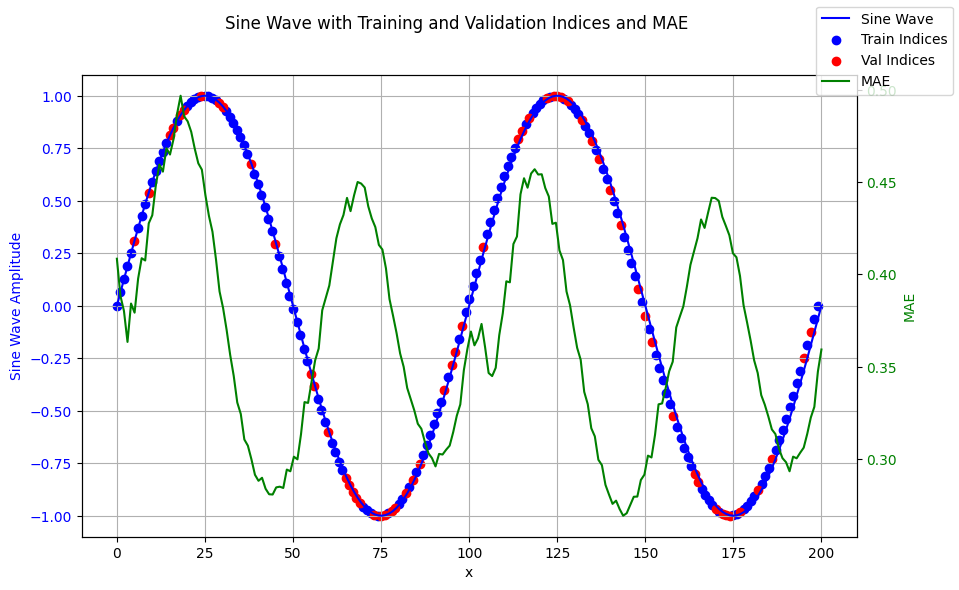

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Read the entire content of the file
with open('train_val_indices.csv', 'r') as f:
    content = f.read()

# Extract the training and validation indices using regular expressions
train_indices = re.findall(r'Train indices: \[([0-9\s]+)\]', content)
val_indices = re.findall(r'Val indices: \[([0-9\s]+)\]', content)

# Convert the extracted indices to lists of integers
train_indices = list(map(int, train_indices[0].split()))
val_indices = list(map(int, val_indices[0].split()))

# Print the extracted indices to verify
print("Train Indices:", np.sort(train_indices))
print("Validation Indices:", np.sort(val_indices))

# Generate the sine wave
x = np.linspace(0, 2, 200)
sine_wave = np.sin(2 * np.pi * x)

# Generate the second dataset (e.g., cosine wave)
second_data = np.cos(2 * np.pi * x)

# Create the primary plot with the sine wave
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(np.linspace(0, 200, 200), sine_wave, label='Sine Wave', color='blue')
ax1.set_xlabel('x')
ax1.set_ylabel('Sine Wave Amplitude', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Mark the training indices with blue
ax1.scatter(train_indices, sine_wave[train_indices], color='blue', label='Train Indices')

# Mark the validation indices with red
ax1.scatter(val_indices, sine_wave[val_indices], color='red', label='Val Indices')

# Create a secondary y-axis and plot the second dataset
ax2 = ax1.twinx()
ax2.plot(np.linspace(0, 200, 200), mae, label='MAE', color='green')
ax2.set_ylabel(r'MAE', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add labels and legend
fig.suptitle('Sine Wave with Training and Validation Indices and MAE')
fig.legend()
ax1.grid(True)

# Show the plot
plt.show()

In [24]:
for i in range(ntsteps):
  print(i,mae[i])

0 0.4084506332874298
1 0.3884129822254181
2 0.3801403343677521
3 0.36340785026550293
4 0.3841937184333801
5 0.37925171852111816
6 0.39769116044044495
7 0.4087299108505249
8 0.4075062870979309
9 0.42763644456863403
10 0.43200841546058655
11 0.4482090175151825
12 0.4594147503376007
13 0.4556143581867218
14 0.4682861566543579
15 0.46487534046173096
16 0.4732304811477661
17 0.48683011531829834
18 0.4967331886291504
19 0.4855576753616333
20 0.48283466696739197
21 0.4771636724472046
22 0.46799150109291077
23 0.46011674404144287
24 0.4567103683948517
25 0.4429488778114319
26 0.43164700269699097
27 0.42306551337242126
28 0.40798741579055786
29 0.39071905612945557
30 0.3817358911037445
31 0.3698812425136566
32 0.35638174414634705
33 0.3450377285480499
34 0.33061331510543823
35 0.3243676722049713
36 0.31056204438209534
37 0.30720973014831543
38 0.29985249042510986
39 0.2914581596851349
40 0.288193017244339
41 0.2898218035697937
42 0.2838989496231079
43 0.28090280294418335
44 0.28076186776161194


In [ ]:

"""
New Code to generate data from .vti files

"""

import numpy as np

data = np.load("../sample_data/data_full.npy")
print(data.shape)

data_sampled = data[:,:,::4, ::4, ::4]
np.save('../sample_data/data.npy', data_sampled)
print(data_sampled.shape, data_sampled.shape[2]*data_sampled.shape[3]*data_sampled.shape[4])

"""
Old Code to generate data from .vti files

"""
# import os
# import numpy as np
# import vtk
# from vtk.util import numpy_support

# # Directory containing the VTI files

# def load_vti_file(file_name):
# 		reader = vtk.vtkXMLImageDataReader()
# 		reader.SetFileName(file_name)
# 		reader.Update()
# 		return reader.GetOutput()

# def extract_data(image_data):
# 		X_array = image_data.GetPointData().GetArray("X")
# 		Y_array = image_data.GetPointData().GetArray("Y")
# 		Z_array = image_data.GetPointData().GetArray("Z")
# 		vorticity_array = image_data.GetPointData().GetArray("Vorticity")

# 		num_points = image_data.GetNumberOfPoints()
# 		print(num_points)
# 		X = np.zeros(num_points)
# 		Y = np.zeros(num_points)
# 		Z = np.zeros(num_points)
# 		vorticity = np.zeros(num_points)
# 		temperature = np.zeros(num_points)

# 		for i in range(num_points):
# 				# velocity = velocity_array.GetTuple(i)
# 				# u_array[i] = velocity[0]
# 				# v_array[i] = velocity[1]
# 				# w_array[i] = velocity[2]
# 				X[i] = X_array.GetValue(i)
# 				Y[i] = Y_array.GetValue(i)
# 				Z[i] = Z_array.GetValue(i)
# 				vorticity[i] = vorticity_array.GetValue(i)

# 		return X, Y, Z, vorticity

# def reshape_arrays_to_grid(X, Y, Z, vorticity, temperature, x_res, y_res, z_res):
#     x_reshaped = np.reshape(X, (z_res, y_res, x_res))
#     y_reshaped = np.reshape(Y, (z_res, y_res, x_res))
#     z_reshaped = np.reshape(Z, (z_res, y_res, x_res))
#     vorticity_reshaped = np.reshape(vorticity, (z_res, y_res, x_res))
#     return x_reshaped, y_reshaped, z_reshaped, vorticity_reshaped


# vti_directory = '../sample_data/vtiData/'  # Change this to your VTI files directory
# ntsteps = 201
# nFeatures = 4
# nx = 70
# ny = 68
# nz = 59

# # file_name = vti_directory + "data_0.vti"
# # image_data = load_vti_file(file_name)

# # x, y, z, vorticity = extract_data(image_data)

# # x = np.reshape(x, (nx, ny, nz), order='F')
# # y = np.reshape(y, (nx, ny, nz), order='F')
# # z = np.reshape(z, (nx, ny, nz), order='F')
# # vorticity = np.reshape(vorticity, (nx, ny, nz), order='F')

# # levels = np.linspace(0, 10, 11)

# # plt.figure(figsize=(8, 6))
# # plt.contourf(x[:, :, 50], y[:, :, 50], vorticity[:, :, 50], cmap='YlOrRd',levels=levels)
# # plt.colorbar(label='Temperature (C)')
# # plt.xlabel('X')
# # plt.ylabel('Z')
# # plt.title('Temperature Contour at y = 12')
# # plt.grid(True)
# # plt.axis('equal')
# # plt.savefig("temp.png")


# data_list = []
# for tstep in range(ntsteps):
# 	file = vti_directory+"data_%i.vti"%tstep
# 	print(file)
# 	vtiData = load_vti_file(file)
# 	listData = extract_data(vtiData)
# 	arrayData = np.zeros(shape=(nFeatures,nx,ny,nz))

# 	for i in range(nFeatures):
# 		arrayData[i] = np.reshape(listData[i], (nx, ny, nz), order='F')
	
# 	data_list.append(arrayData)

# data = np.array(data_list)
# np.save('../sample_data/data.npy', data)
